In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

### Reading Data

In [2]:
data= pd.read_excel('onion_data.xlsx')

In [3]:
data.head()

,Date,Arrival
0,2008-01-01,670.0
1,2008-01-02,1675.0
2,2008-01-03,600.0
3,2008-01-04,545.0
4,2008-01-05,1440.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     974 non-null    datetime64[ns]
 1   Arrival  974 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.3 KB


In [5]:
data.describe()

,Arrival
count,974.000000
mean,975.130493
std,278.730596
min,0.100000
25%,800.000000
50%,940.000000
75%,1123.750000
max,3040.000000


Text(0.5, 0, 'Arrival of Onions')

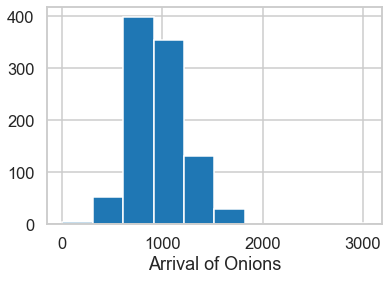

In [6]:
data['Arrival'].hist()
plt.xlabel('Arrival of Onions')

<AxesSubplot:xlabel='Arrival', ylabel='Density'>

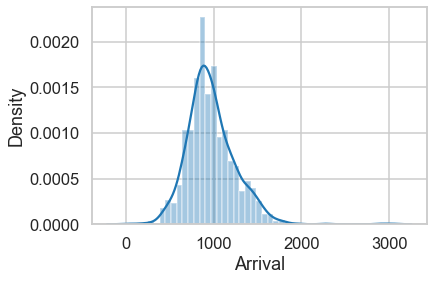

In [7]:
import seaborn as sns
sns.distplot(data['Arrival'])

From the density plot,We can say that arrival of onions is following a normal distribution


In [8]:
data=data.set_index('Date')
data.head()

,Arrival
Date,
2008-01-01,670.0
2008-01-02,1675.0
2008-01-03,600.0
2008-01-04,545.0
2008-01-05,1440.0


<AxesSubplot:xlabel='Date'>

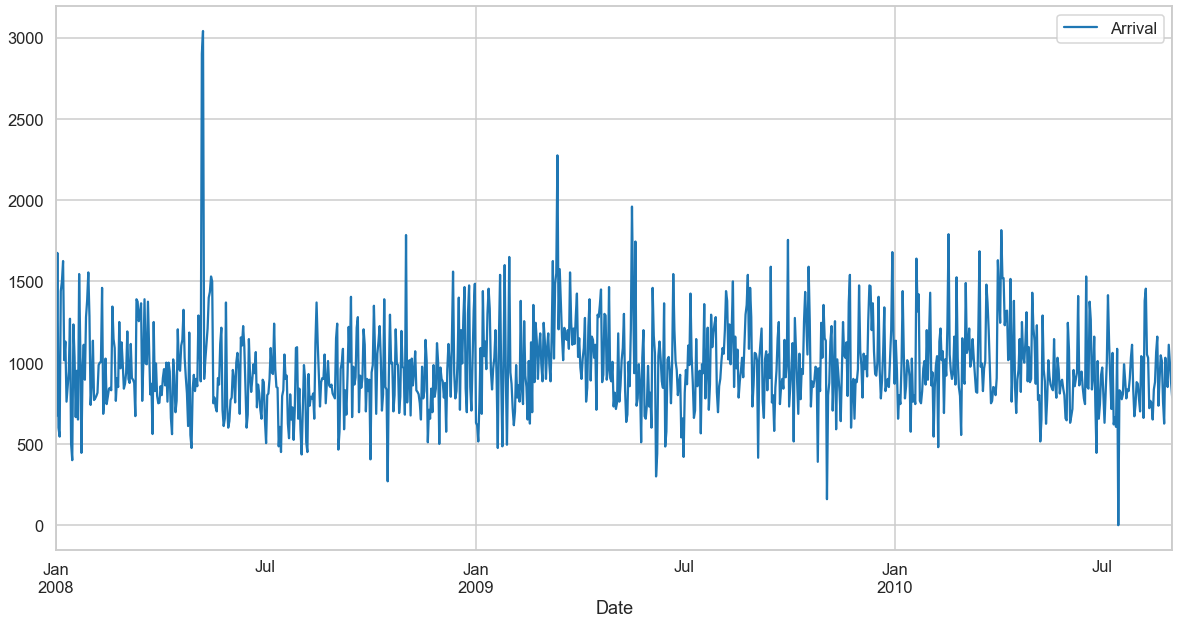

In [9]:
data.plot(figsize=(20,10))

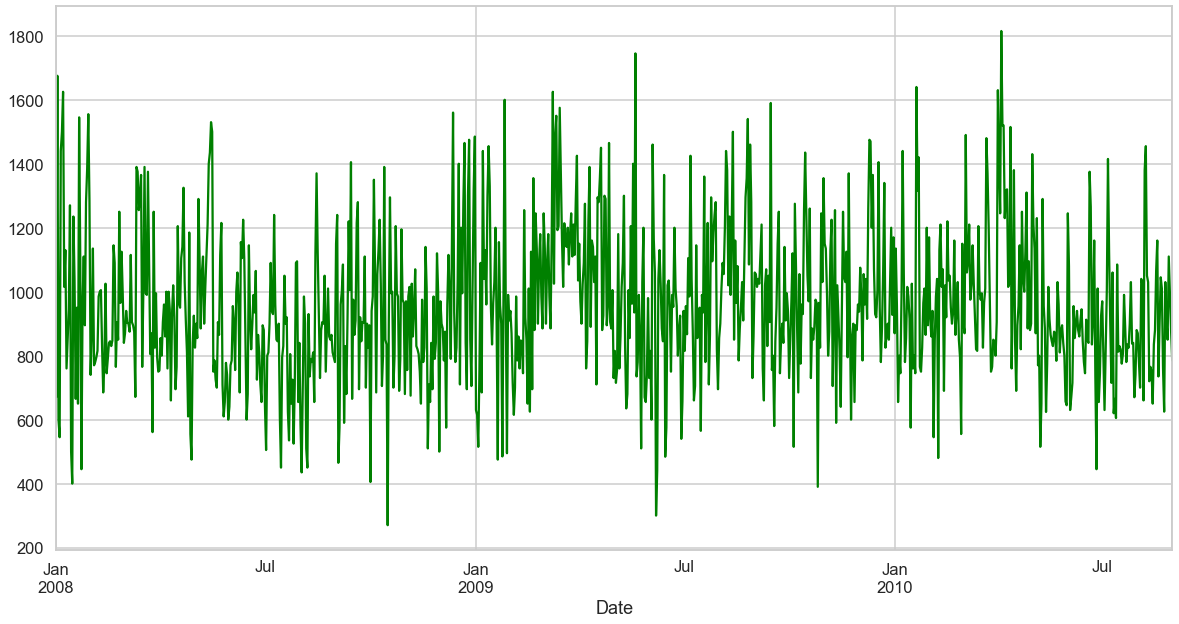

In [10]:
from hampel import hampel
data_cleaned = hampel(data.Arrival, window_size=8, n=3)
data_cleaned.plot(style="g-", figsize=(20,10))
plt.show()

In [11]:
data = data_cleaned.to_frame()

In [12]:
split=round(len(data.Arrival)/2)
onion_data1,onion_data2=data.Arrival[0:split],data.Arrival[split:]
mean1,mean2=onion_data1.mean(),onion_data2.mean()
std1,std2=onion_data1.std(),onion_data2.std()

print('Mean1=%f , Mean2=%f' %(mean1,mean2))
print('Standard deviation1=%f , Standard deviation2=%f' %(std1,std2))

Mean1=951.855236 , Mean2=965.998973
Standard deviation1=246.443307 , Standard deviation2=229.775627


Mean and variance of the splitted data is almost same. So we can say the data is *stationery*.

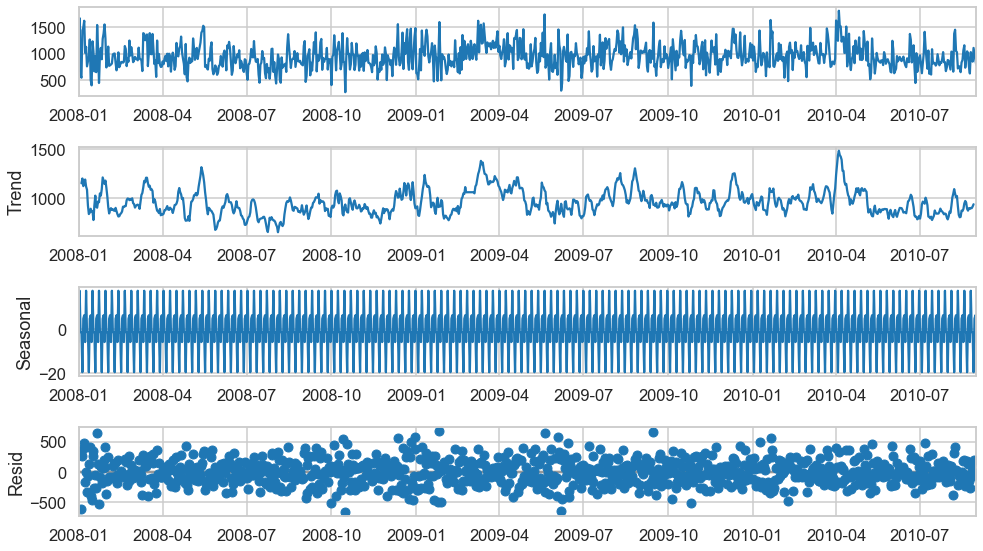

In [13]:
pylab.rcParams['figure.figsize'] = (14, 8)
ts_decomp=sm.tsa.seasonal_decompose(data,model='additive')
ts_decomp.plot()
plt.show()

In [14]:
train = data[:912] # 30 months -> 912 days!
val = data[912:943] # 1 month -> 31 days
test = data[943:] # 1 month -> 31 days

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 912 entries, 2008-01-01 to 2010-06-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Arrival  912 non-null    float64
dtypes: float64(1)
memory usage: 14.2 KB


In [16]:
val.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2010-07-01 to 2010-07-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Arrival  31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2010-08-01 to 2010-08-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Arrival  31 non-null     float64
dtypes: float64(1)
memory usage: 496.0 bytes


<AxesSubplot:xlabel='Date'>

<Figure size 1080x504 with 0 Axes>

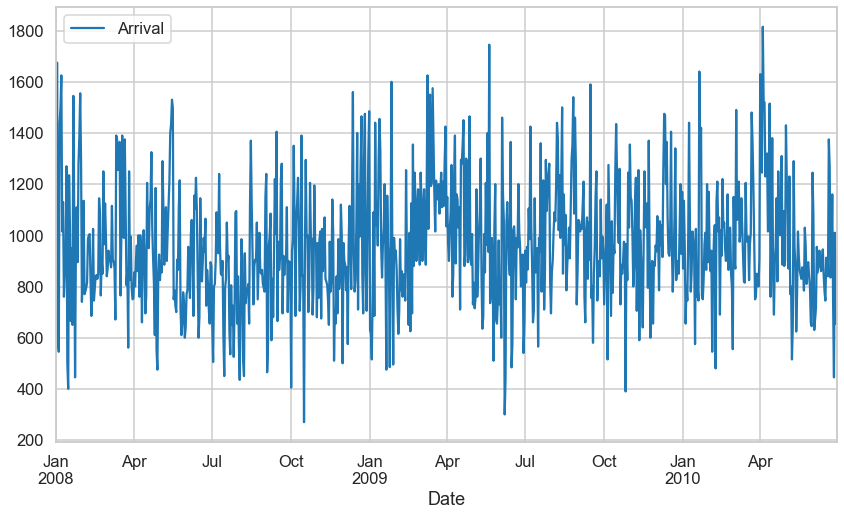

In [18]:
plt.figure(figsize=(15,7))
train.plot()

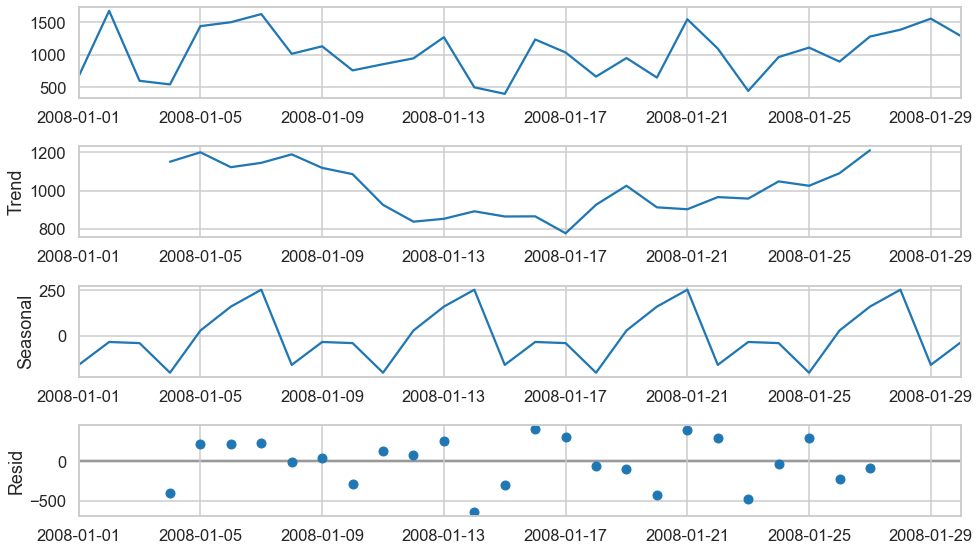

In [19]:
pylab.rcParams['figure.figsize'] = (14, 8)
ts_decomp=sm.tsa.seasonal_decompose(train[:30],model='additive')
ts_decomp.plot()
plt.show()

In [20]:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.818858
p-value: 0.000000


As p=0 Dickey Fuller Test also says that data is stationery [Data is said to be stationery if p<0.05]

### Plotting ACF and PACF

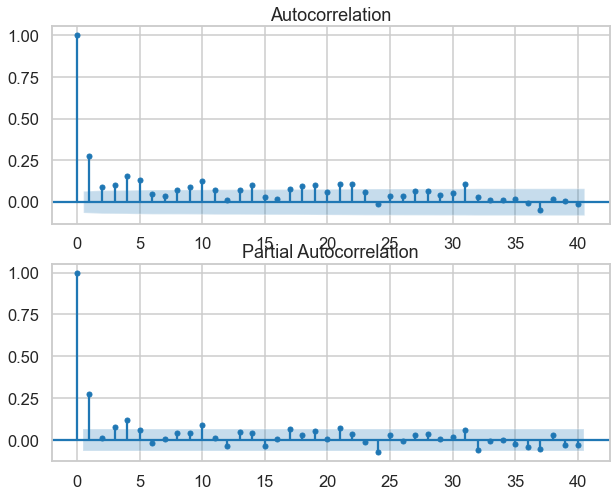

In [21]:
fig,ax =plt.subplots(2, figsize=(10,8))
ax[0] = sm.graphics.tsa.plot_acf(train['Arrival'],ax=ax[0],lags=40)
ax[1] = sm.graphics.tsa.plot_pacf(train['Arrival'],ax=ax[1],lags=40)

In [22]:
train['seasonal_order_diff'] = train['Arrival']-train['Arrival'].shift(7)
train.head()

,Arrival,seasonal_order_diff
Date,,
2008-01-01,670.0,NaN
2008-01-02,1675.0,NaN
2008-01-03,600.0,NaN
2008-01-04,545.0,NaN
2008-01-05,1440.0,NaN


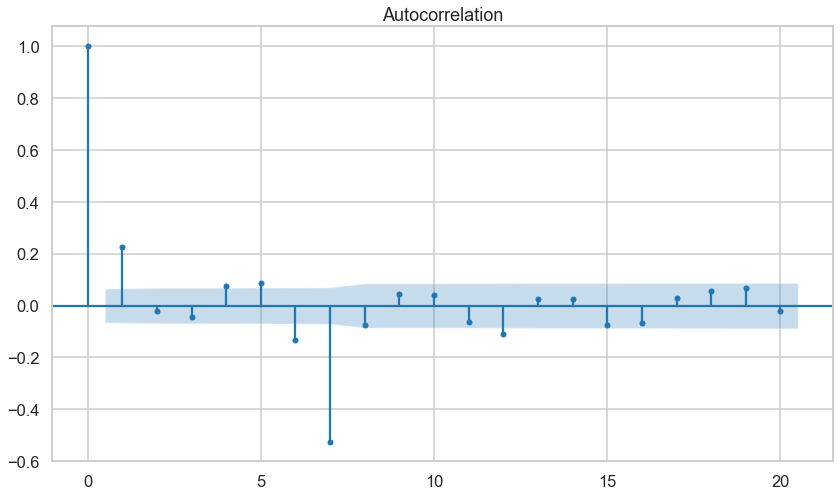

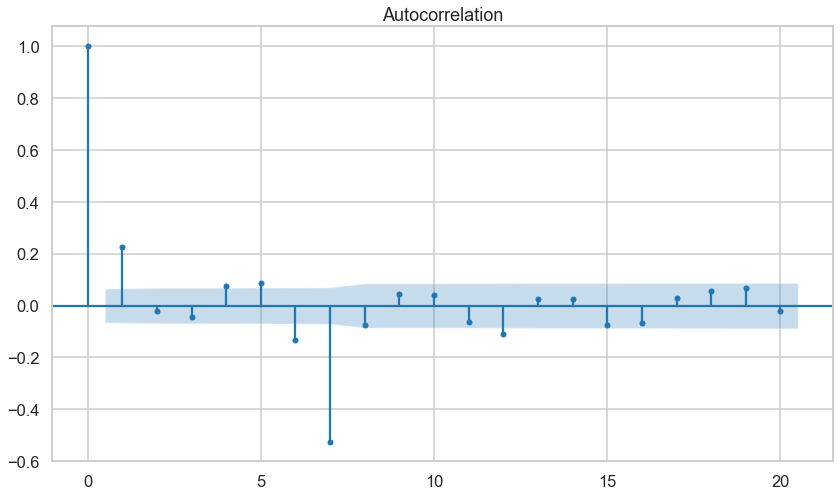

In [23]:
sm.graphics.tsa.plot_acf(train['seasonal_order_diff'].dropna(),lags=20)

- ARIMA(1,0,1) X (1,1,2)7
- ARIMA(1,0,0) X (1,1,0)7
- ARIMA(1,0,1) X (1,1,0)7
- ARIMA(1,0,1) X (1,1,1)7

In [24]:
model1 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(1, 0, 1),seasonal_order=(1, 1, 2, 7))
model_aic1 = model1.fit()
print(model_aic1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8798      0.043     20.260      0.000       0.795       0.965
ma.L1         -0.7310      0.058    -12.620      0.000      -0.845      -0.617
ar.S.L7       -0.3431      0.446     -0.770      0.441      -1.216       0.530
ma.S.L7       -0.7247      0.461     -1.574      0.116      -1.627       0.178
ma.S.L14      -0.2729      0.462     -0.591      0.554      -1.178       0.632
sigma2       5.35e+04   4354.455     12.286      0.000     4.5e+04     6.2e+04


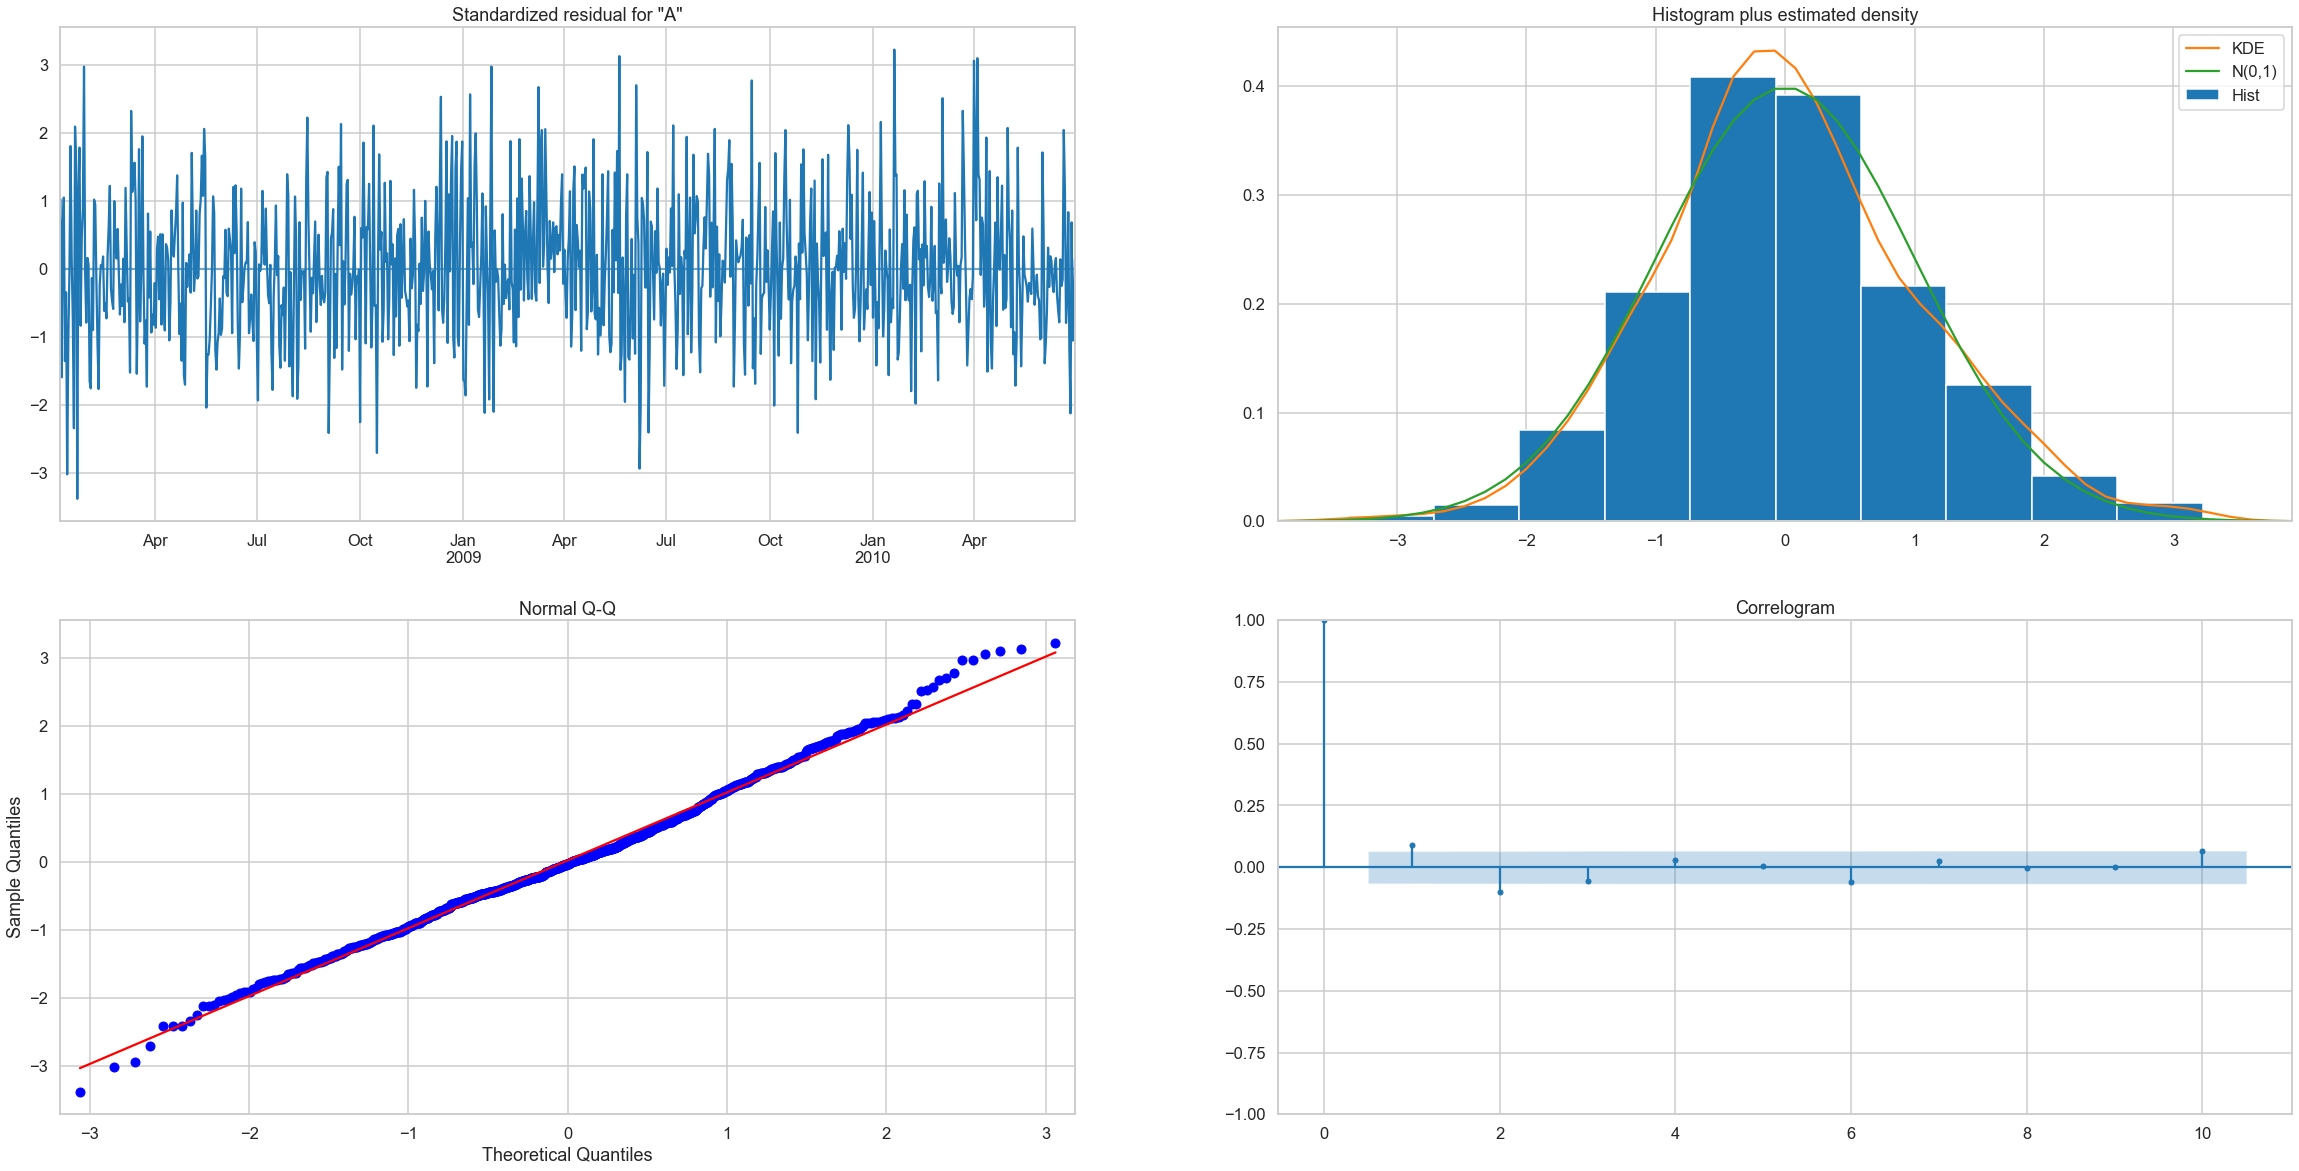

In [25]:
model_aic1.plot_diagnostics(figsize=(40,20))
plt.show()

<AxesSubplot:xlabel='Date'>

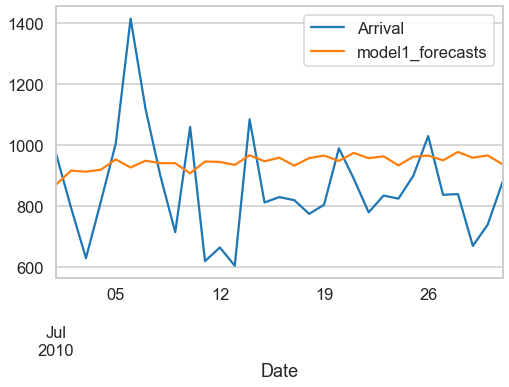

In [26]:
data['model1_forecasts'] = model_aic1.predict(start=912, end=974, dynamic=True)
data[912:943][['Arrival','model1_forecasts']].plot(figsize=(8,5))

In [27]:
model2 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(1, 0, 0),seasonal_order=(1, 1, 0, 7))
model_aic2 = model2.fit() 
print(model_aic2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2498      0.029      8.523      0.000       0.192       0.307
ar.S.L7       -0.5443      0.027    -20.386      0.000      -0.597      -0.492
sigma2       7.41e+04   3208.600     23.095      0.000    6.78e+04    8.04e+04


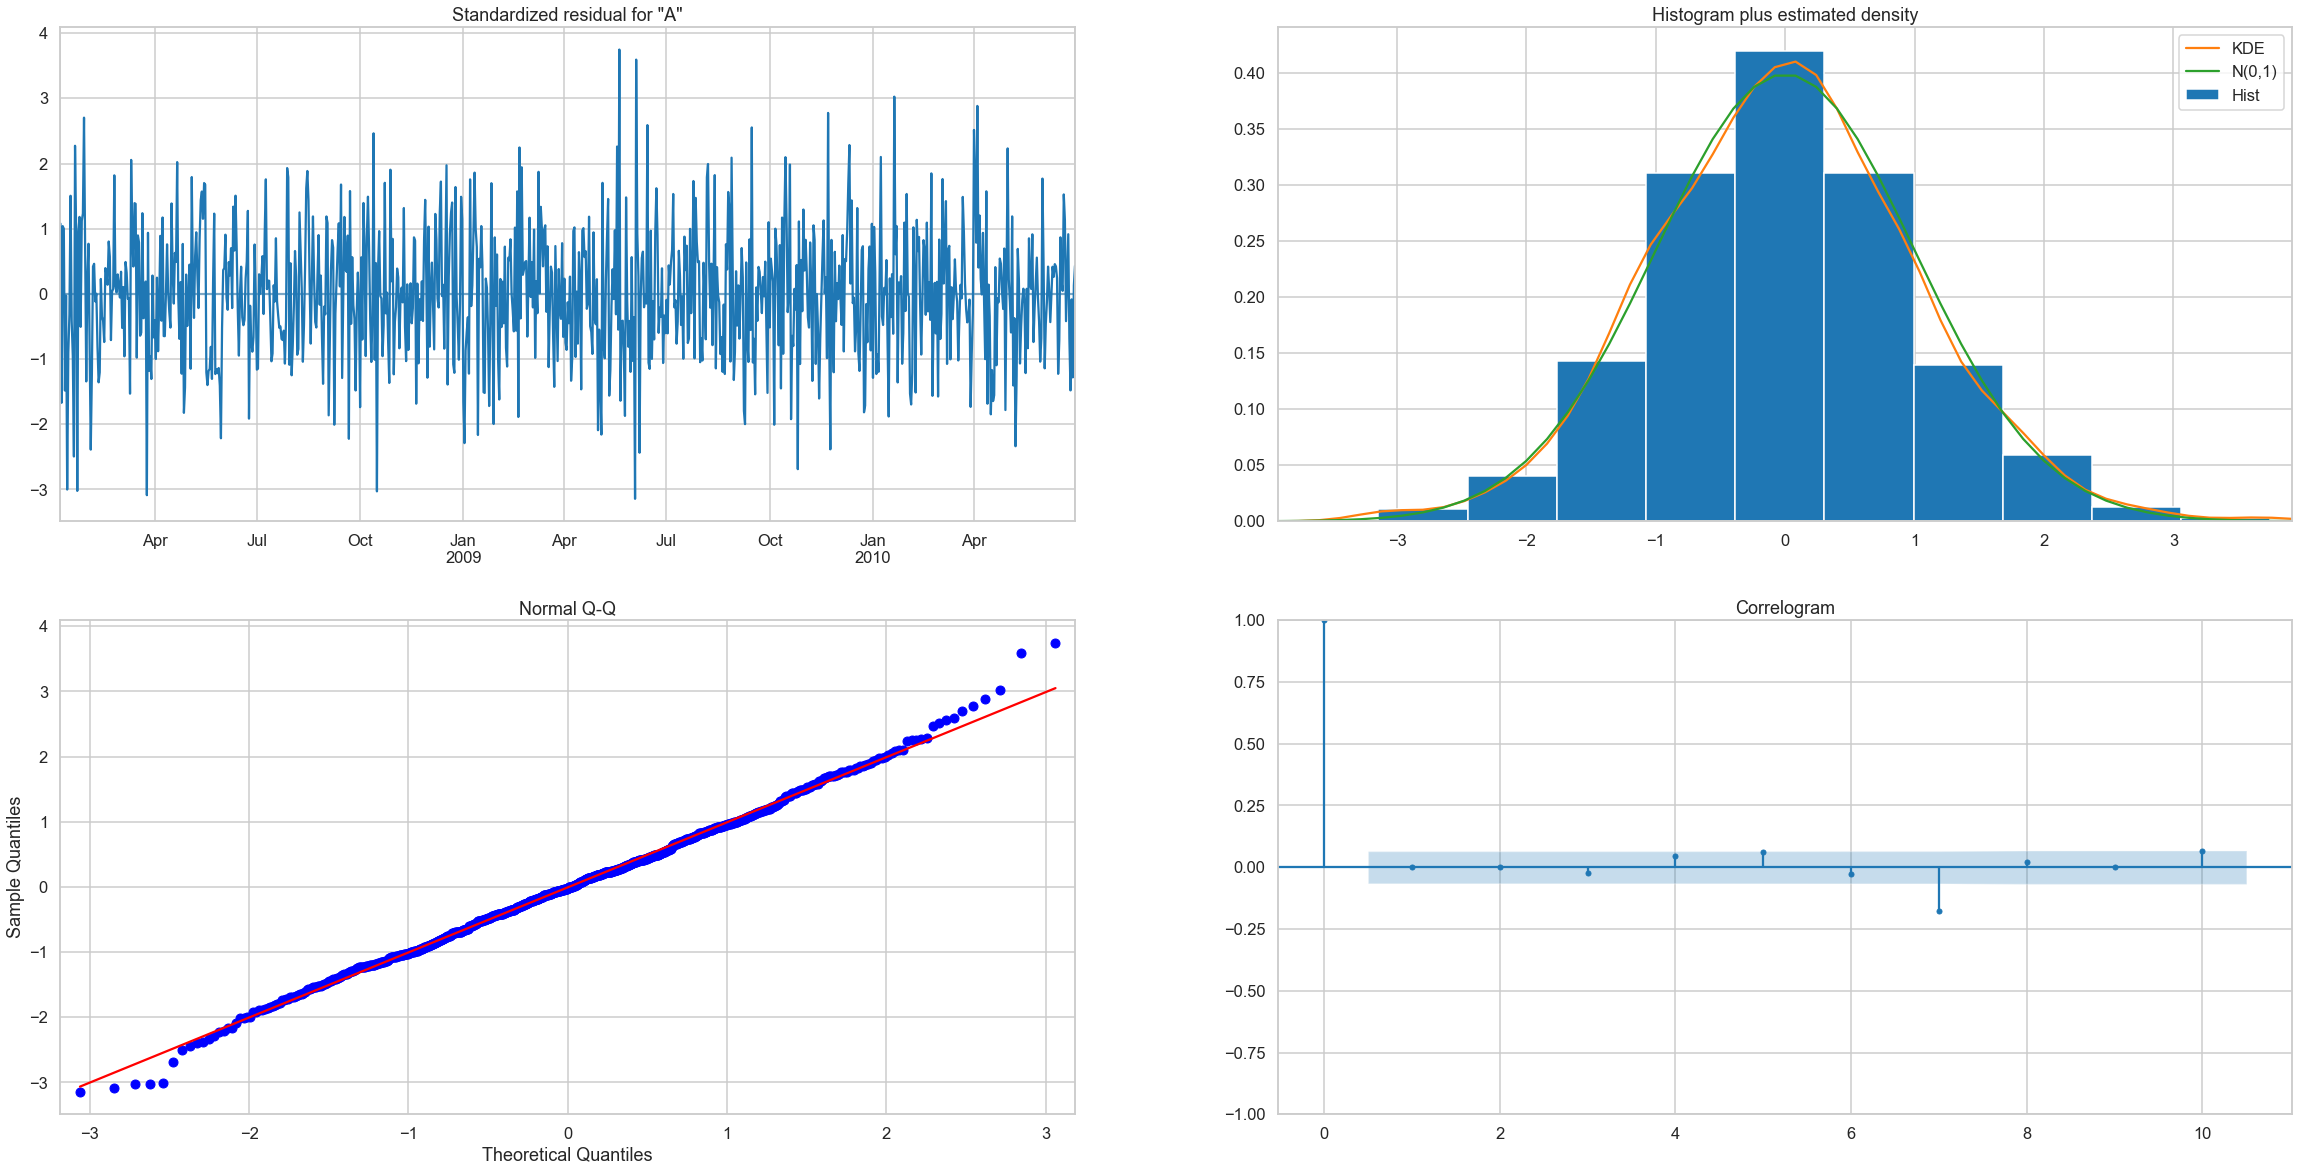

In [28]:
model_aic2.plot_diagnostics(figsize=(40,20))
plt.show()

<AxesSubplot:xlabel='Date'>

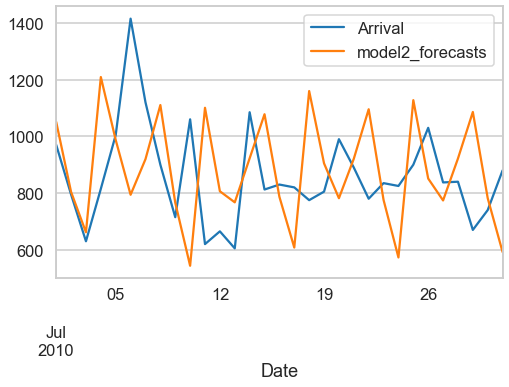

In [29]:
data['model2_forecasts'] = model_aic2.predict(start=912, end=943, dynamic=True)
data[912:943][['Arrival','model2_forecasts']].plot(figsize=(8,5))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2277      0.128      1.783      0.075      -0.023       0.478
ma.L1          0.0235      0.133      0.177      0.860      -0.237       0.285
ar.S.L7       -0.5438      0.027    -20.230      0.000      -0.596      -0.491
sigma2       7.41e+04   3224.179     22.983      0.000    6.78e+04    8.04e+04


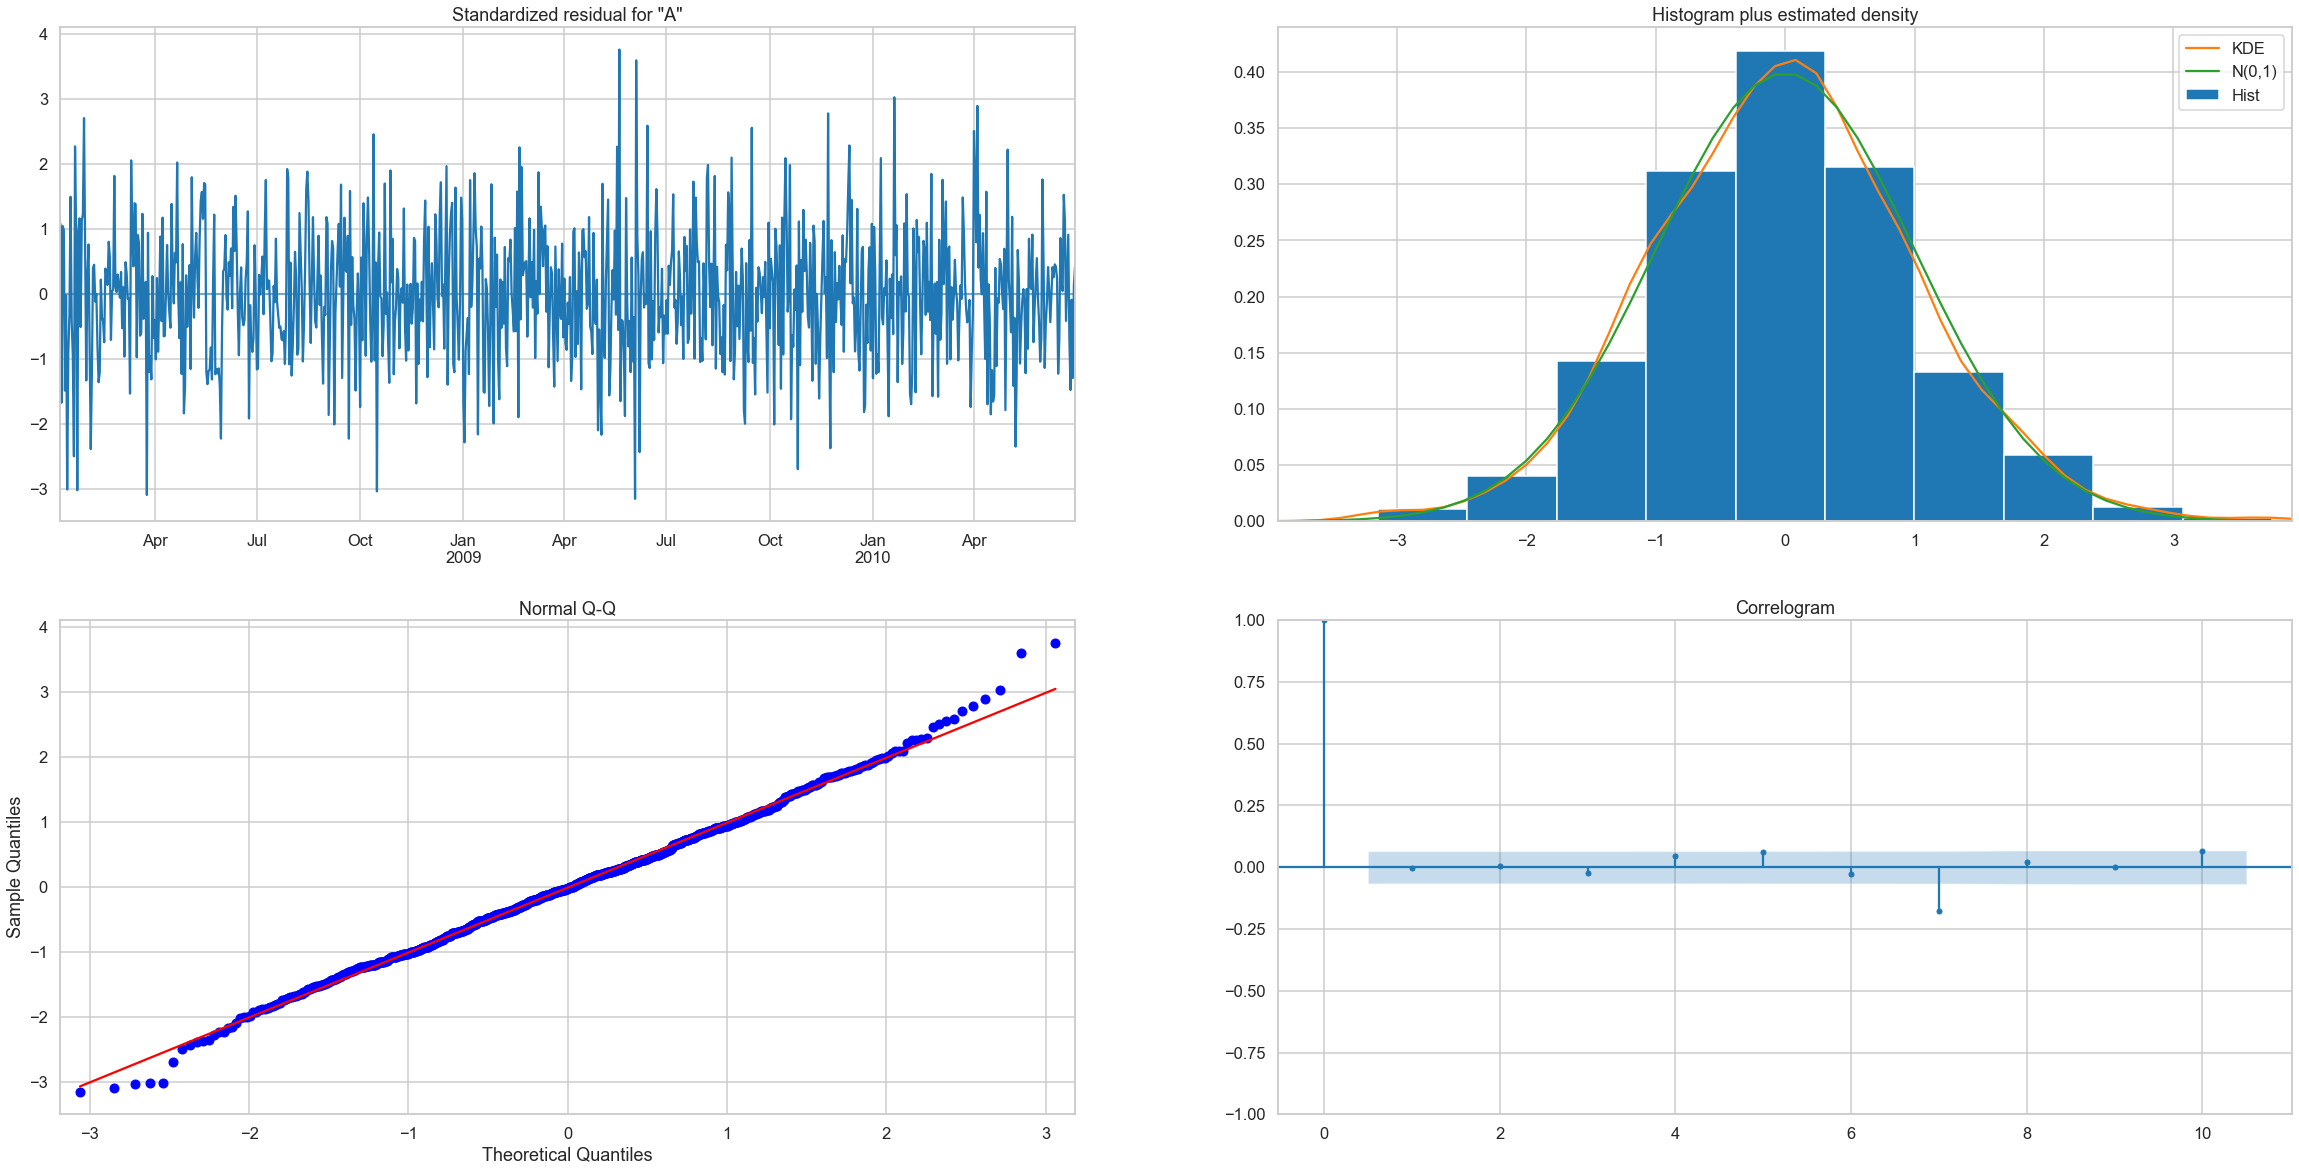

<AxesSubplot:xlabel='Date'>

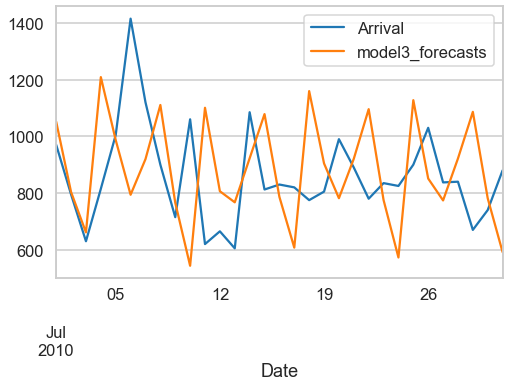

In [30]:
model3 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(1, 0, 1),seasonal_order=(1, 1, 0, 7))
model_aic3 = model3.fit() 
print(model_aic3.summary().tables[1])

model_aic3.plot_diagnostics(figsize=(40,20))
plt.show()

data['model3_forecasts'] = model_aic3.predict(start=912, end=943, dynamic=True)
data[912:943][['Arrival','model3_forecasts']].plot(figsize=(8,5))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9986      0.014     70.140      0.000       0.971       1.026
ma.L1         -0.9008      0.018    -51.454      0.000      -0.935      -0.866
ar.S.L7       -0.0875      0.035     -2.531      0.011      -0.155      -0.020
ma.S.L7       -0.9970      0.061    -16.442      0.000      -1.116      -0.878
sigma2       5.48e+04   3778.856     14.501      0.000    4.74e+04    6.22e+04


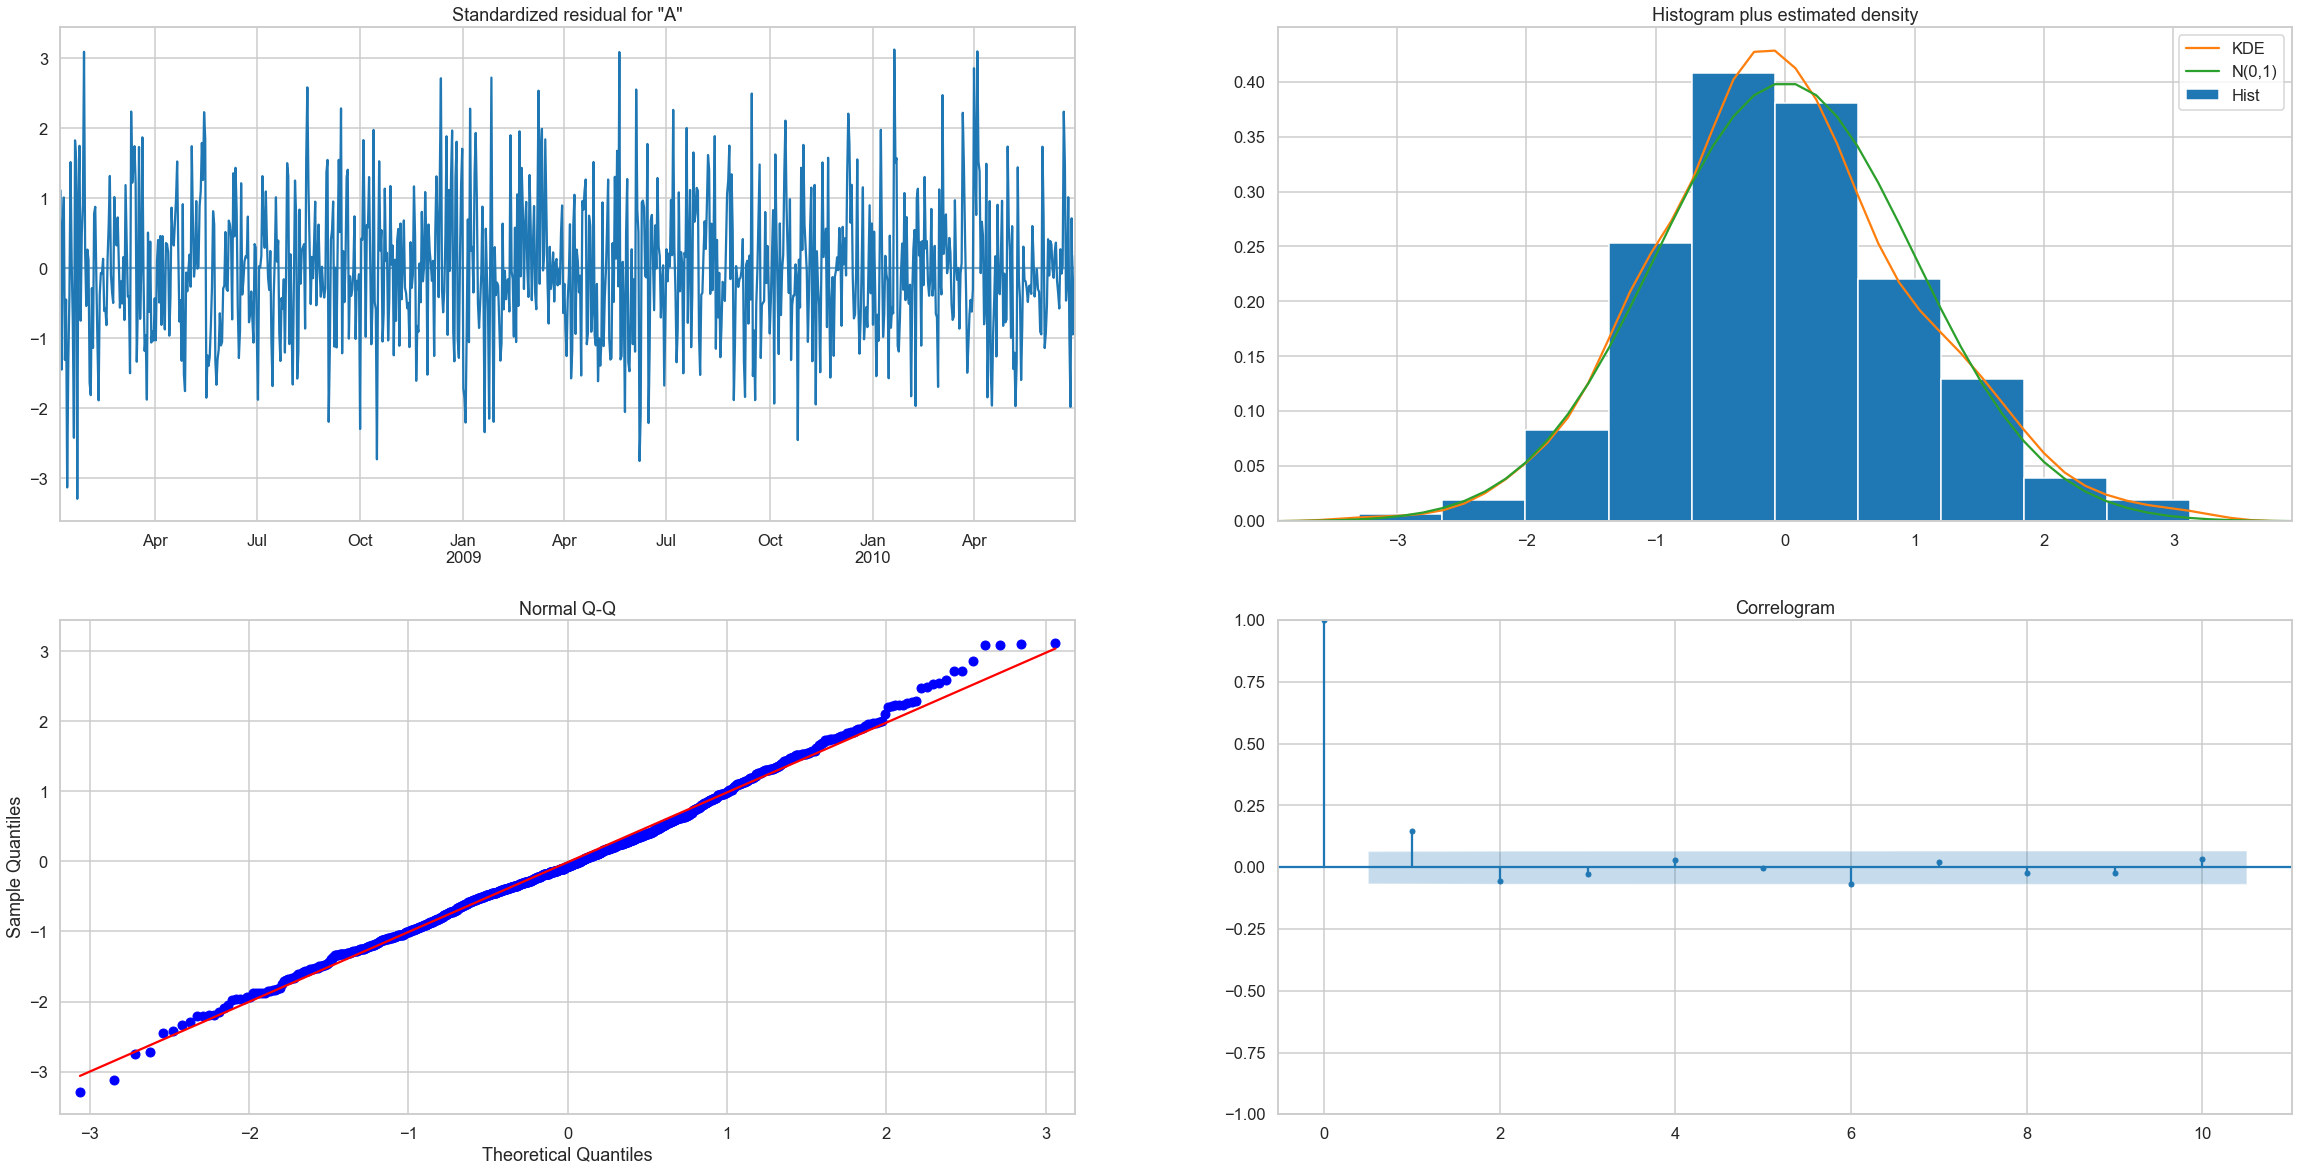

<AxesSubplot:xlabel='Date'>

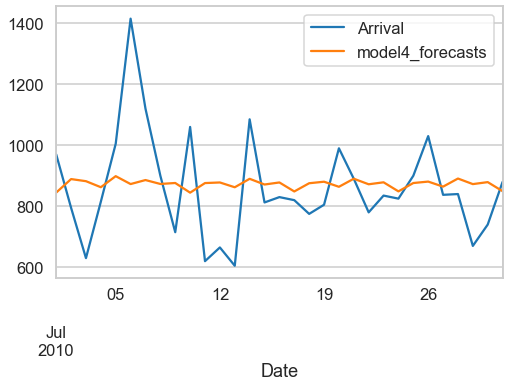

In [31]:
model4 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(1, 0, 1),seasonal_order=(1, 1, 1, 7))
model_aic4 = model4.fit() 
print(model_aic4.summary().tables[1])

model_aic4.plot_diagnostics(figsize=(40,20))
plt.show()

data['model4_forecasts'] = model_aic4.predict(start=912, end=943, dynamic=True)
data[912:943][['Arrival','model4_forecasts']].plot(figsize=(8,5))

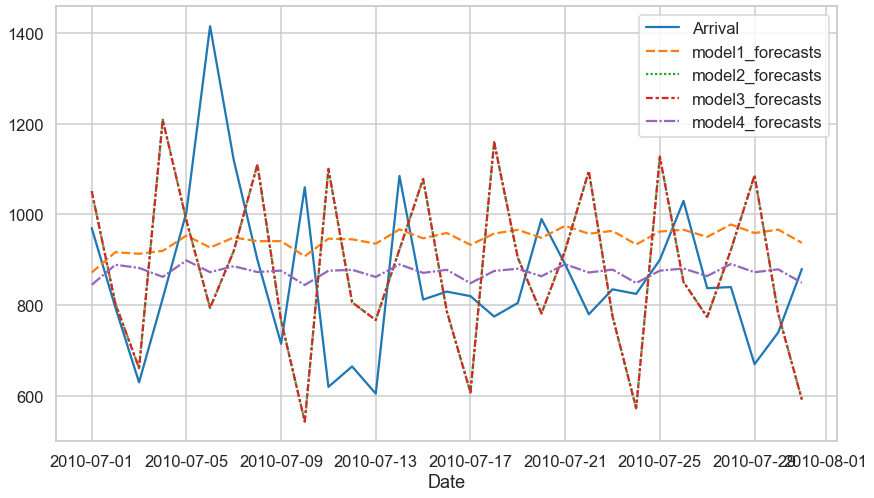

In [32]:
plt.figure(figsize=(14,8))
sns.lineplot(data=data[912:943])
plt.show()

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [34]:
print('MAPE for ARIMA(1,0,1)X(1,1,2)7: {}'.format(mean_absolute_percentage_error(data[912:943]['Arrival'],data[912:943]['model1_forecasts'])))
print('MAPE for ARIMA(1,0,0)X(1,1,0)7: {}'.format(mean_absolute_percentage_error(data[912:943]['Arrival'],data[912:943]['model2_forecasts'])))
print('MAPE for ARIMA(1,0,1)X(1,1,0)7: {}'.format(mean_absolute_percentage_error(data[912:943]['Arrival'],data[912:943]['model3_forecasts'])))
print('MAPE for ARIMA(1,0,1)X(1,1,1)7: {}'.format(mean_absolute_percentage_error(data[912:943]['Arrival'],data[912:943]['model4_forecasts'])))

MAPE for ARIMA(1,0,1)X(1,1,2)7: 20.22731183783804
MAPE for ARIMA(1,0,0)X(1,1,0)7: 23.711884741112808
MAPE for ARIMA(1,0,1)X(1,1,0)7: 23.716389025714676
MAPE for ARIMA(1,0,1)X(1,1,1)7: 15.177492081439178


### Validation forecasts

<AxesSubplot:xlabel='Date'>

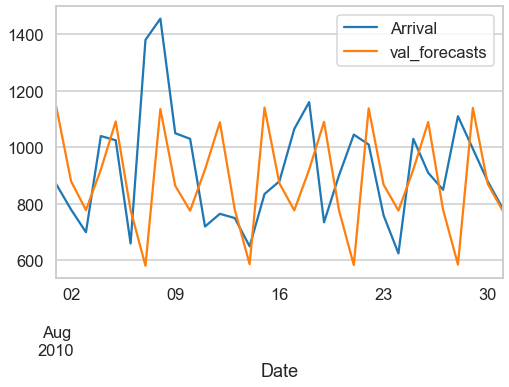

In [35]:
data['val_forecasts'] = model_aic3.predict(start=943, end=974, dynamic=True)
data[943:974][['Arrival','val_forecasts']].plot(figsize=(8,5))